In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import repeat
from extra_packages.OutputInterface import OutputInterface
import extra_packages.sperhical_expansion as se
import SFALinearPulse as SFA_Lin
from matplotlib.colors import LogNorm
from scipy.special import sph_harm
from scipy.optimize import curve_fit

In [2]:
import multiprocessing
#import ipyparallel as ipp
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
pool = multiprocessing.Pool(processes=cpus)

In [3]:
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2     # This choice should make things symmetric

In [4]:
def plot_M_grid(M_grid, px_list, pz_list, log=False, log_scale = 1e-4):
    """
    Function to plot the calculated grids
    """
    plt.figure(facecolor='white', figsize=(12,6))

    M2_grid = np.abs(M_grid)**2
    MMax = np.max(M2_grid)

    if log:
        plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
                   cmap='inferno', norm=LogNorm(vmin=MMax*log_scale, vmax=MMax),
                   interpolation = 'bicubic', aspect = 1.)
    else:
        plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
                   cmap='inferno', interpolation = 'bicubic', aspect = 1.)

    plt.ylabel("$p_x$")
    plt.xlabel("$p_z$")
    plt.colorbar()
    plt.show()

In [5]:
file_name = 'output_files/allene_align_Cl.out'
#center1 = np.array([-0.0006371178, -0.0012884863, 1.4927029103])
#center2 = np.array([-0.0005622321, -0.0001058155, 0.0015786766])
#center = (center1 + center2)/2
#print(center)
center = [0.0102200000, 0.0080900000, 1.2885300000]  # In Å
output = OutputInterface(file_name, shift_center=center)
orbital_nr = None

if orbital_nr == None:
    orbital_nr = output.HOMO
else:
    output.load_orbital(orbital_nr)

Ip = -output.saved_orbitals[orbital_nr][0]
kappa = np.sqrt(2*Ip)

In [6]:
output.HOMO

27

### Plot the f_lm's to find a good area for matching!

In [8]:
plot_list = np.linspace(10, 12, 75)
f_lms = se.laplace_several_r(output.eval_orbital_spherical, plot_list, 30, orbital_nr=orbital_nr)

Evaluating at r=16.0000 	 Nr. 75/75

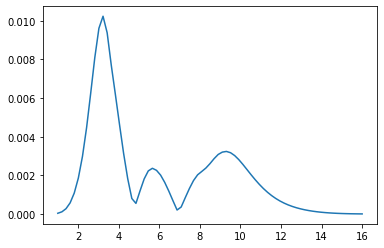

In [45]:
sign, l, m = 0, 6, 3

plt.figure(facecolor='white')
plt.plot(plot_list, np.abs(f_lms[:, sign, l, m]), label='Laplace')
plt.show()

/home/mads/.local/lib/python3.8/site-packages/pyshtools/shclasses/shcoeffs.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, :lmax] = _np.fliplr(mnegative)[:, :lmax]
/home/mads/.local/lib/python3.8/site-packages/pyshtools/shclasses/shcoeffs.py:2821: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[:, lmax:] = mpositive
/home/mads/.local/lib/python3.8/site-packages/pyshtools/shclasses/shcoeffs.py:3141: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


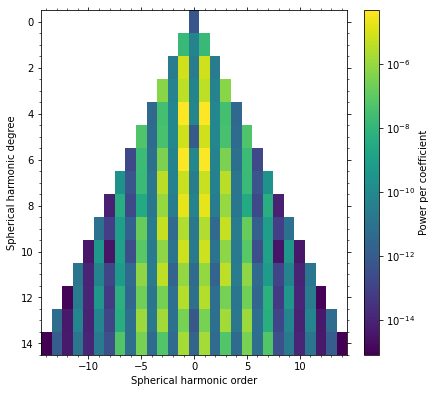

array([[[ 2.79176032e-06+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j],
        [-2.61753774e-05+0.00000000e+00j,
          5.53860330e-05+4.25722712e-04j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.000000

In [9]:
se.spherical_expansion(lambda theta, phi: output.eval_orbital_spherical(6., theta, phi, orbital_nr), 30, True)

### Fit to the selected region to match Clm's

In [7]:
r_list = np.linspace(10, 12, 30)
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 30, Ip, orbital_nr=orbital_nr, threshold=1e-4)

Evaluating at r=12.0000 	 Nr. 30/30
Now fitting!
Done!


In [23]:
l = 4
m = 1
print(clm_array[0,l,m])
print(clm_array[1,l,m])

(1.3275142144121033-0.9878098668313016j)
(-1.327514214246359-0.9878098670049836j)


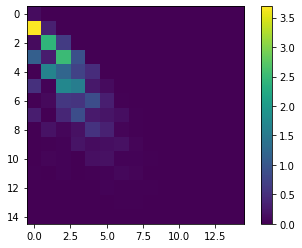

In [17]:
plt.imshow(np.abs(clm_array[0]))
plt.colorbar()

In [22]:
m = 4
print((-1j)**m)

(1+0j)


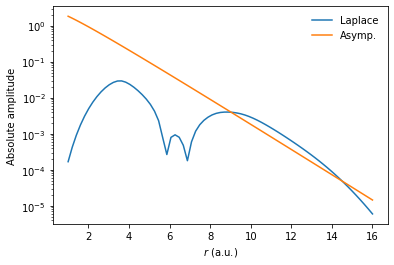

In [51]:
def asymp(r, clm):
    return clm * r**(1/kappa - 1) * np.exp(-kappa*r)

sign, l, m = 0, 5, 3

plt.figure(facecolor='white')
plt.plot(plot_list, np.abs(f_lms[:, sign, l, m]), label='Laplace')
plt.plot(plot_list, np.abs(asymp(plot_list, clm_array[sign, l, m])), label='Asymp.')
plt.xlabel('$r$ (a.u.)')
plt.ylabel('Absolute amplitude')
plt.legend(frameon=False)
plt.yscale('log')
plt.show()

### Let's look at SFA results with this...

In [52]:
N = 50
pz_list = np.linspace(-1.5, 1.5, N)
px_list = np.linspace(-1, 1., N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.

In [53]:
SP_asymp_martiny = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")

In [54]:
M_grid = np.array(pool.starmap(SP_asymp_martiny.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array))))

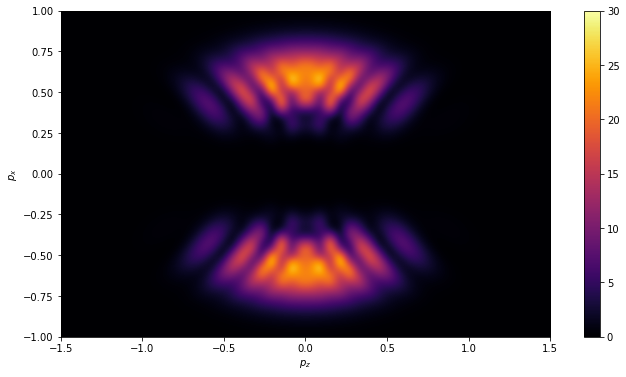

In [55]:
plot_M_grid(M_grid, px_list, pz_list, log=False)

### Dipole stuff

In [14]:
alpha_list = np.array([-4.8346788E+00, -7.5323924E+00, 4.4804579E+01])
print(alpha_list)

[-4.8346788 -7.5323924 44.804579 ]


In [15]:
SP_dip = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="dipole2")

In [16]:
M_grid_dip = np.array(pool.starmap(SP_dip.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array), repeat(alpha_list))))

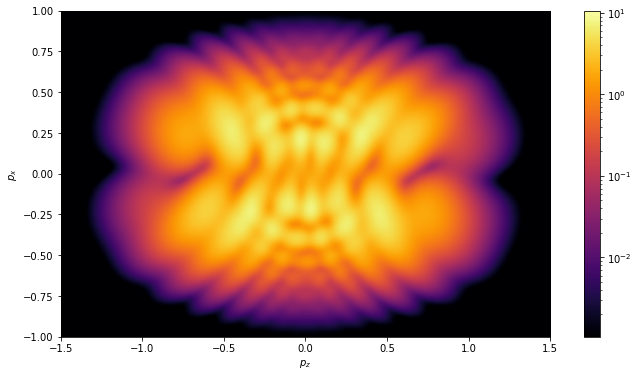

In [17]:
plot_M_grid(M_grid_dip, px_list, pz_list, log=True)

### Chiral stuffs

In [56]:
# First mirror the state in the z-axis!
chiral_clm = np.zeros_like(clm_array)
for l in range(clm_array.shape[1]):
    for m in range(-l, l+1):
        sign = 0 if m >= 0 else 1
        chiral_clm[sign, l, abs(m)] = (-1)**(l+m) * clm_array[sign, l, abs(m)]

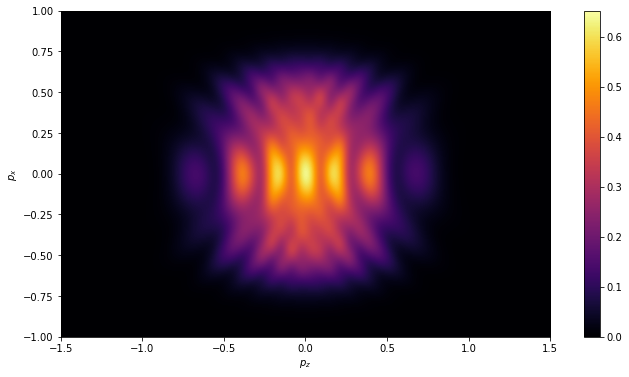

In [27]:
SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")

M_grid = np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array))))
plot_M_grid(M_grid, px_list, pz_list, log=False)

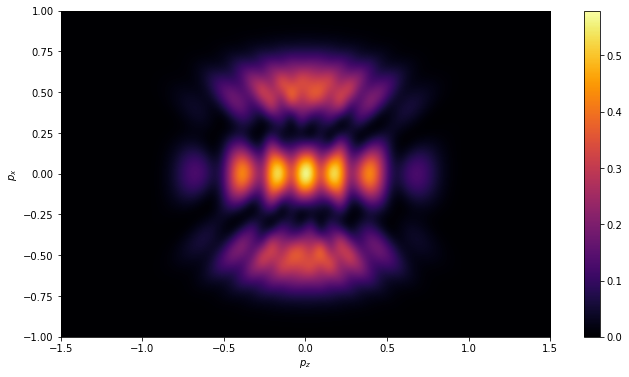

In [30]:
M_grid = np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(chiral_clm))))
plot_M_grid(M_grid, px_list, pz_list, log=False)

In [27]:
N = 50
pz_list = np.linspace(-1.5, 1.5, N)
px_list = np.linspace(-1, 1., N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.

In [57]:
SP = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")

#max_l = 3
OAM_list = [-2,-1,0,1,2]
OAM_grids = []
chiral_grids = []

for i in [1,-1]:
    OAM_grids = []

    for OAM in OAM_list:
        print(f'Calculating for OAM : {OAM}')
        SP.OAM = int(OAM)
        if i == 1:
            OAM_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array)))))
        else:
            OAM_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(chiral_clm)))))
    chiral_grids.append(OAM_grids[:])

Calculating for OAM : -2
Calculating for OAM : -1
Calculating for OAM : 0
Calculating for OAM : 1
Calculating for OAM : 2
Calculating for OAM : -2
Calculating for OAM : -1
Calculating for OAM : 0
Calculating for OAM : 1
Calculating for OAM : 2


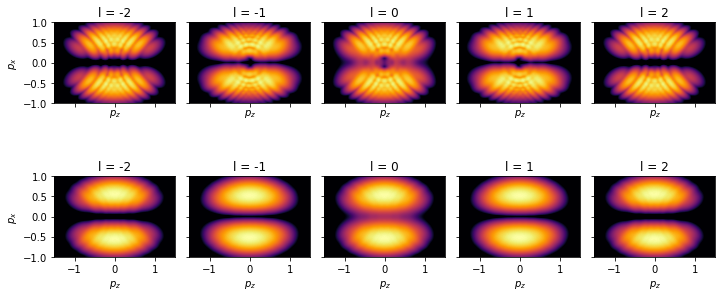

In [58]:
fig, axs = plt.subplots(2, len(OAM_list), sharey=True, sharex = True, figsize=(10,5), facecolor='white')
plt.tight_layout()
for j, OAM_grids in enumerate(chiral_grids):
    for i, Ml_grid in enumerate(OAM_grids):
        Ml2_grid = np.abs(Ml_grid)**2
        Ml_max = np.max(Ml2_grid)
        filter_list = Ml2_grid > np.max(Ml2_grid * 1e-8)
        Ml2_grid[np.logical_not(filter_list)] = 1e-8

        axs[j, i].imshow(np.flip(Ml2_grid,0), cmap='inferno', aspect=1, interpolation = 'bicubic', norm=LogNorm(vmin=Ml_max*1e-4, vmax=Ml_max),
                      extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)))
        axs[j, i].set_title(f'l = {OAM_list[i]}')
        axs[j, i].set_xlabel('$p_z$')

    axs[0,0].set_ylabel('$p_x$')
    axs[1,0].set_ylabel('$p_x$')

plt.tight_layout()

### PEVD

In [59]:
OAM_list = [-3, 3]

PEVD_grids = []

N = 100
pz_list = np.linspace(-1.5, 1.5, 2*N)
px_list = np.linspace(0, 1.4, N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.

for OAM in OAM_list:
    print(f'Calculating for OAM : {OAM}')
    SP.OAM = int(OAM)
    PEVD_grids.append(np.array(pool.starmap(SP.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array)))))

Calculating for OAM : -3
Calculating for OAM : 3


In [60]:
OAM_m, OAM_p = PEVD_grids
OAM2_m = np.abs(OAM_m)**2
OAM2_p = np.abs(OAM_p)**2

PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))
PEVD = np.nan_to_num(PEVD,nan=0)

filter_list1 = OAM2_m > np.max(OAM2_m*1e-4)
filter_list2 = OAM2_p > np.max(OAM2_p*1e-4)
combined_filter = np.logical_or(filter_list1, filter_list2)
PEVD[np.logical_not(combined_filter)] = 0
#PEVD[np.logical_not(filter_list1)] = 0
#plt.imshow(np.flip(diff_grid.T), cmap='seismic', interpolation='bicubic')

/tmp/ipykernel_37725/3026794779.py:5: RuntimeWarning: invalid value encountered in true_divide
  PEVD = 2 * ((OAM2_p - OAM2_m) / (OAM2_p + OAM2_m))


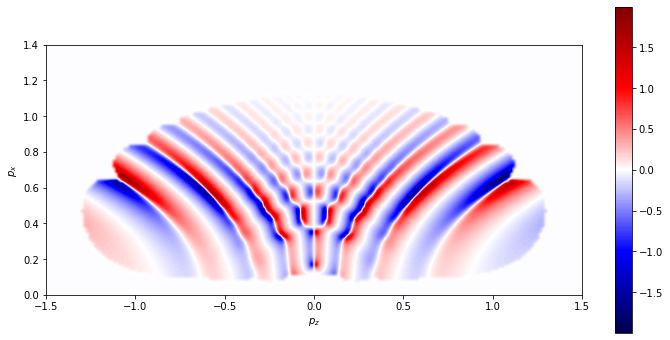

In [61]:
plt.figure(facecolor='white', figsize=(12,6))

plt.imshow(np.flip(PEVD,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
           cmap='seismic', #norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic')#, aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()

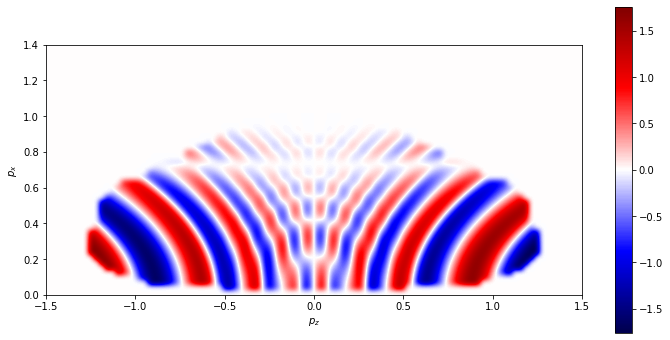

In [45]:
plt.figure(facecolor='white', figsize=(12,6))

plt.imshow(np.flip(PEVD,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
           cmap='seismic', #norm=LogNorm(vmin=MMax*1e-4, vmax=MMax),
           interpolation = 'bicubic')#, aspect = 1.)

plt.ylabel("$p_x$")
plt.xlabel("$p_z$")
plt.colorbar()